In [17]:
import uproot4
import coffea
%pylab inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import awkward
from coffea import hist, processor
from coffea.analysis_objects import JaggedCandidateArray
from coffea.nanoaod import NanoEvents

from dask.distributed import Client, progress
import distributed

from condor_utils import make_htcondor_cluster
import utils

import mplhep
plt.style.use(mplhep.style.CMS)

Populating the interactive namespace from numpy and matplotlib


/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Part 1 : Photon BDT variables with no $\tau$ selections

In [2]:
class MyProcessor(processor.ProcessorABC):
    
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            
            "diphoton_mass":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("diphoton_mass","Diphoton mass",500,0,500)),
            
            "leading_gamma_pt_normalized":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("leading_gamma_pt_normalized","$\gamma_1$~$P_T$/$m_{ \gamma\gamma}$",100,0,10)),
            
            "trailing_gamma_pt_normalized":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("trailing_gamma_pt_normalized","$\gamma_2$~$P_T$/$m_{ \gamma\gamma}$",100,0,10)), 
            
            "leading_gamma_eta":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("leading_gamma_eta","$\gamma_1$~$\eta$",500,-5,5)),
            
            "trailing_gamma_eta":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("trailing_gamma_eta","$\gamma_2$~$\eta$",500,-5,5)),
            
            "leading_pixel_seed_veto":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("leading_pixel_seed_veto","$\gamma_1$~pixel seed veto",2,0,2)),
            
            "trailing_pixel_seed_veto":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("trailing_pixel_seed_veto","$\gamma_2$~pixel seed veto",2,0,2)),
            
            "max_gamma_ID_MVA":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("max_gamma_ID_MVA","Max $\gamma$ ID MVA",200,-1,1)),
            
            "min_gamma_ID_MVA":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("min_gamma_ID_MVA","Min $\gamma$ ID MVA",200,-1,1)),
            
            "nJets":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("nJets","NJets",12,0,12)),
            
            "jet_1_pt":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("jet_1_pt","Jet 1 $P_T$",1000,0,1000)),
            
            "jet_1_eta":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("jet_1_eta","Jet 1 $\eta$",500,-2.5,2.5)),
            
            "jet_2_pt":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("jet_2_pt","Jet 2 $P_T$",1000,0,1000)),
            
            "jet_2_eta":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("jet_2_eta","Jet 2 $\eta$",500,-2.5,2.5)),
        }
            )
    
    def fillHists(self, histCollectionName, events):
        """Future proofing : Fills histograms based on a passed nanoaod.events collections belonging to a particular histCollection
        The histCollections are noTau, oneHadTau, oneLepTau. An appropriate collection of events must be passed in
        and all the histograms will be filled"""
        pass
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        xsecs = {
            "GJets40100":20790,
            "GJets100200":9238,
            "GJets200400":2305,
            "GJets400600":274.4,
            "GJets600Inf":93.46,
            "DYJets":6104,
            "ZGToLLG":117.864,
            "DiPhoton":88.36,
            "signal":0.029 * 0.0027 * 0.06 * 2,
        }
        lumi = 137.2
        output = self.accumulator.identity()
        dataset = events.metadata["dataset"]
        
        
        goodEvents = events[(events.ggMass >= 0)] #no tau selections!
        ggMass = goodEvents.ggMass
        
        #JaggedCandidateArray - one array for each object
        
        gHidx = awkward.JaggedArray.fromregular(goodEvents.gHidx)
        tauHidx = awkward.JaggedArray.fromregular(goodEvents.tauHidx)
        
        
        photons = goodEvents.Photon[gHidx]
        
        output["sumw"][dataset] += events.genWeight.sum()
        weightToFill = goodEvents.genWeight * xsecs[dataset] * 1000 * lumi
        
        output["diphoton_mass"].fill(
        dataset = dataset,
        diphoton_mass = ggMass,
        weight = weightToFill)
     

        output["leading_gamma_pt_normalized"].fill(
        dataset = dataset,
        leading_gamma_pt_normalized = photons.pt[:,0]/ggMass, 
        weight = weightToFill)
        
        output["trailing_gamma_pt_normalized"].fill(
        dataset = dataset,
        trailing_gamma_pt_normalized = photons.pt[:,1]/ggMass,
        weight = weightToFill)
        
        output["leading_gamma_eta"].fill(
        dataset = dataset,
        leading_gamma_eta = photons.eta[:,0],
        weight = weightToFill)
        
        output["trailing_gamma_eta"].fill(
        dataset = dataset,
        trailing_gamma_eta = photons.eta[:,1],
        weight = weightToFill)
        
        output["leading_pixel_seed_veto"].fill(
        dataset = dataset,
        leading_pixel_seed_veto = photons.pixelSeed[:,0],
        weight = weightToFill)
        
        output["trailing_pixel_seed_veto"].fill(
        dataset = dataset,
        trailing_pixel_seed_veto = photons.pixelSeed[:,1],
        weight = weightToFill)
        
        output["max_gamma_ID_MVA"].fill(
        dataset = dataset,
        max_gamma_ID_MVA = photons.mvaID.max(),
        weight = weightToFill)
        
        output["min_gamma_ID_MVA"].fill(
        dataset = dataset,
        min_gamma_ID_MVA = photons.mvaID.min(),
        weight = weightToFill)
        
        jets = goodEvents.Jet
        
        output["nJets"].fill(
        dataset = dataset,
        nJets = jets.counts,
        weight = weightToFill)
        
        output["jet_1_pt"].fill(
        dataset = dataset,
        jet_1_pt = jets[jets.counts >= 1].pt[:,0],
        weight = weightToFill[jets.counts >= 1])
        
        output["jet_1_eta"].fill(
        dataset = dataset,
        jet_1_eta = jets[jets.counts >= 1].eta[:,0],
        weight = weightToFill[jets.counts >= 1])
        
        output["jet_2_pt"].fill(
        dataset = dataset,
        jet_2_pt = jets[jets.counts >= 2].pt[:,1],
        weight = weightToFill[jets.counts >= 2])
        
        output["jet_2_eta"].fill(
        dataset = dataset,
        jet_2_eta = jets[jets.counts >= 2].eta[:,1],
        weight = weightToFill[jets.counts >= 2])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
import glob
background_fileset = {
    "GJets40100":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-40To100_17____v1/*.root"),
    "GJets100200":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-100To200_17____v1/*.root"),
    "GJets200400":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-200To400_17____v1/*.root"),
    "GJets400600":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-400To600_17____v1/*.root"),
    "GJets600Inf":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-600ToInf_17____v1/*.root"),
    "DYJets":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/DYJetsToLL_M-50_17____v1/*.root"),
    "ZGToLLG":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/ZGToLLG_01J_17____v1/*.root"),
    "DiPhoton":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/DiPhotonJetsBox_MGG-80toInf_17____v1/*.root") 
}

signal_fileset = {
    "signal":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/HHggtautau_Era2018_private_prova_vera/*.root"),
}


In [5]:
cluster = make_htcondor_cluster(local=False, dashboard_address=13349)
cluster

In [6]:
cluster.scale(100)

In [7]:
c = Client(cluster)
c

Client Scheduler: tcp://169.228.130.5:26365 Dashboard: http://169.228.130.5:13349/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [9]:
gamma_bg_out = processor.run_uproot_job(
background_fileset,
treename = "Events",
processor_instance = MyProcessor(),
executor = processor.dask_executor,
executor_args={"nano":True, "client":c},)

In [10]:
gamma_signal_out = processor.run_uproot_job(
signal_fileset,
treename = "Events",
processor_instance = MyProcessor(),
executor = processor.futures_executor,
executor_args={"num_workers":8,"nano":True})

In [11]:
gamma_bg_out

{'sumw': defaultdict_accumulator(float,
                         {'GJets40100': 364623.0,
                          'GJets100200': 1512028.0,
                          'GJets200400': 4930186.0,
                          'GJets400600': 1408481.0,
                          'GJets600Inf': 807704.0,
                          'DYJets': 74165797184.0,
                          'ZGToLLG': 1118730457.5,
                          'DiPhoton': 387005828.0}),
 'diphoton_mass': <Hist (dataset,diphoton_mass) instance at 0x7f552b8ca990>,
 'leading_gamma_pt_normalized': <Hist (dataset,leading_gamma_pt_normalized) instance at 0x7f5522ad92d0>,
 'trailing_gamma_pt_normalized': <Hist (dataset,trailing_gamma_pt_normalized) instance at 0x7f5522a06110>,
 'leading_gamma_eta': <Hist (dataset,leading_gamma_eta) instance at 0x7f5522b1c750>,
 'trailing_gamma_eta': <Hist (dataset,trailing_gamma_eta) instance at 0x7f5522b339d0>,
 'leading_pixel_seed_veto': <Hist (dataset,leading_pixel_seed_veto) instance at 0x7f552

In [12]:
gamma_signal_out

{'sumw': defaultdict_accumulator(float, {'signal': 712675.7607421875}),
 'diphoton_mass': <Hist (dataset,diphoton_mass) instance at 0x7f5522b010d0>,
 'leading_gamma_pt_normalized': <Hist (dataset,leading_gamma_pt_normalized) instance at 0x7f5522f69a10>,
 'trailing_gamma_pt_normalized': <Hist (dataset,trailing_gamma_pt_normalized) instance at 0x7f552c904950>,
 'leading_gamma_eta': <Hist (dataset,leading_gamma_eta) instance at 0x7f5522c8b590>,
 'trailing_gamma_eta': <Hist (dataset,trailing_gamma_eta) instance at 0x7f54d27b6d90>,
 'leading_pixel_seed_veto': <Hist (dataset,leading_pixel_seed_veto) instance at 0x7f54d284c950>,
 'trailing_pixel_seed_veto': <Hist (dataset,trailing_pixel_seed_veto) instance at 0x7f552ccf6050>,
 'max_gamma_ID_MVA': <Hist (dataset,max_gamma_ID_MVA) instance at 0x7f5522a06650>,
 'min_gamma_ID_MVA': <Hist (dataset,min_gamma_ID_MVA) instance at 0x7f54d266b150>,
 'nJets': <Hist (dataset,nJets) instance at 0x7f5522879a90>,
 'jet_1_pt': <Hist (dataset,jet_1_pt) instan

In [13]:
from collections import defaultdict
master_hists = {"signal":gamma_signal_out.copy(),"background":gamma_bg_out.copy()}
hists = defaultdict(dict)

for process,master_hist in master_hists.items():
    sumw = master_hist["sumw"].copy()
    sumw = {key:1.0/value for key,value in sumw.items()}
    for quantity, histo in master_hist.items():
        if "sumw" in quantity:
            continue
        temp = histo.copy()
        temp.scale(sumw, axis = "dataset")
        hists[quantity][process] = temp


In [15]:
rebins = {"diphoton_mass":hist.Bin("diphoton_mass","diphoton mass",100,0,500),
          "leading_gamma_pt_normalized":hist.Bin("leading_gamma_pt_normalized","$\gamma_1$ $P_T$/$m_{ \gamma\gamma}$",100,0,10),
         "trailing_gamma_pt_normalized":hist.Bin("trailing_gamma_pt_normalized","$\gamma_2$ $P_T$/$m_{ \gamma\gamma}$",100,0,10),
         "jet_1_pt":hist.Bin("jet_1_pt","Jet 1 $P_T$",100,0,1000),
         "jet_2_pt":hist.Bin("jet_2_pt","Jet 2 $P_T$",100,0,1000),
         "jet_1_eta":hist.Bin("jet_1_eta","Jet 1 $\eta$",125,-2.5,2.5),
         "jet_2_eta":hist.Bin("jet_1_eta","Jet 2 $\eta$",125,-2.5,2.5)}
for rebin_quantity,new_bin in rebins.items():
    for process,histo in hists[rebin_quantity].items():
        hists[rebin_quantity][process] = histo.rebin(rebin_quantity,new_bin)

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


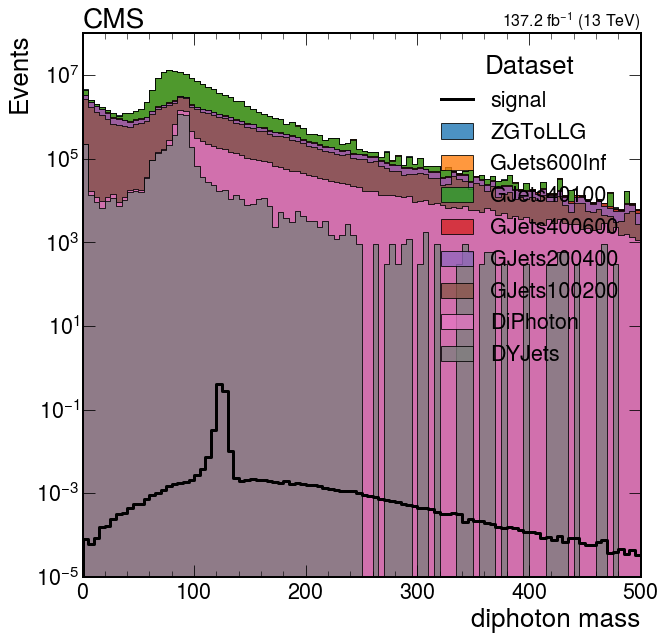

In [18]:
plt.yscale("log")
plt.ylim([1e-5, 1e8])
#plt.ylim([1e5,1e6])
hist.plot1d(hists["diphoton_mass"]["background"],overlay = "dataset", stack = True, fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
})

ax = hist.plot1d(hists["diphoton_mass"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


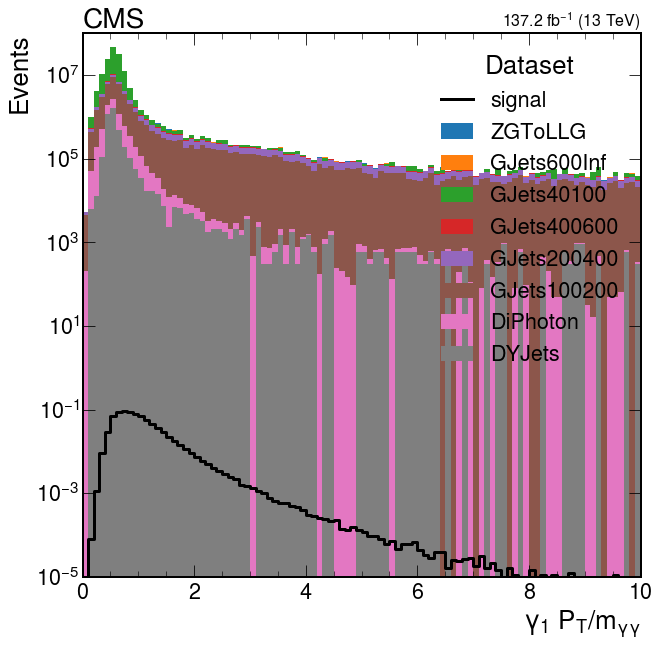

In [19]:
plt.yscale("log")

plt.ylim([1e-5,1e8])
hist.plot1d(hists["leading_gamma_pt_normalized"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["leading_gamma_pt_normalized"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


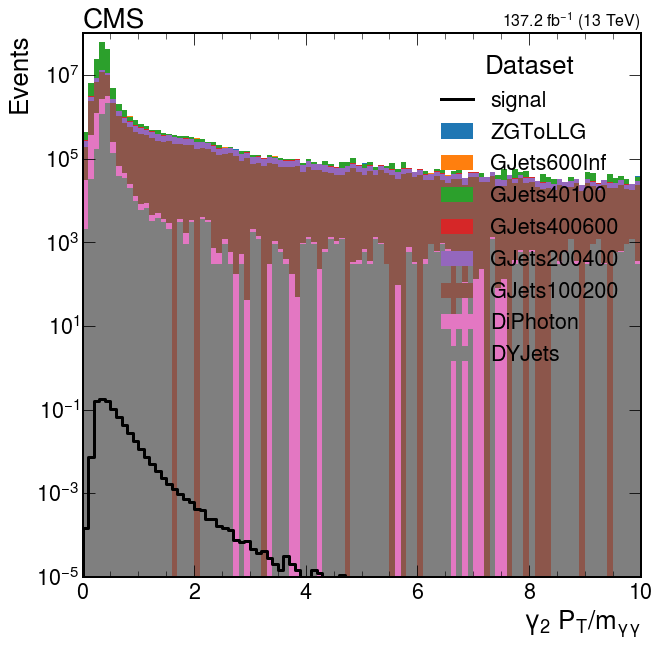

In [20]:
plt.yscale("log")

plt.ylim([1e-5,1e8])
hist.plot1d(hists["trailing_gamma_pt_normalized"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["trailing_gamma_pt_normalized"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


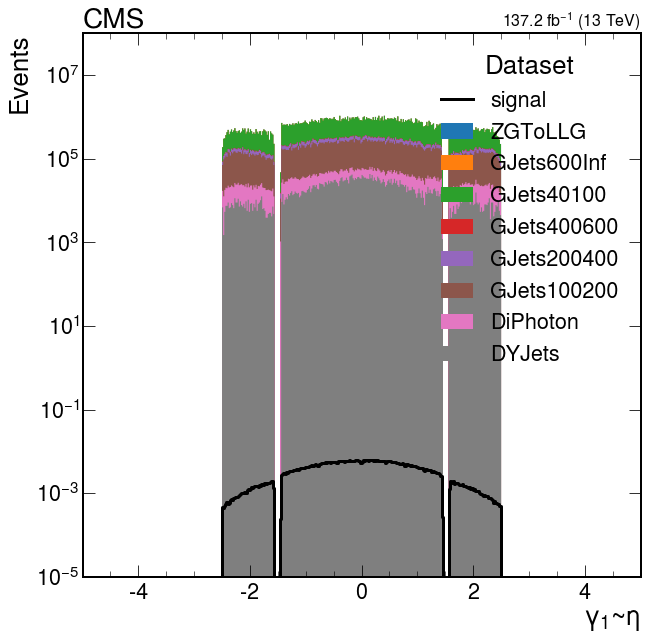

In [21]:
plt.yscale("log")
plt.ylim([1e-5,1e8])
hist.plot1d(hists["leading_gamma_eta"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["leading_gamma_eta"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


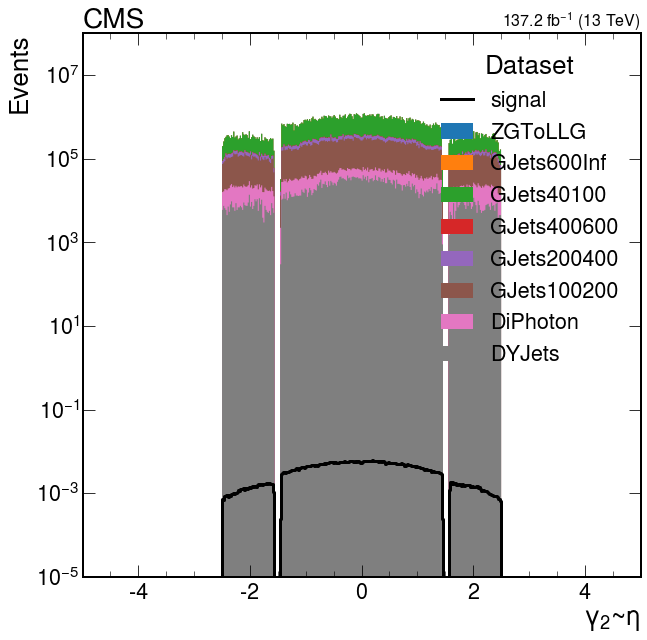

In [22]:
plt.yscale("log")
plt.ylim([1e-5,1e8])
hist.plot1d(hists["trailing_gamma_eta"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["trailing_gamma_eta"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


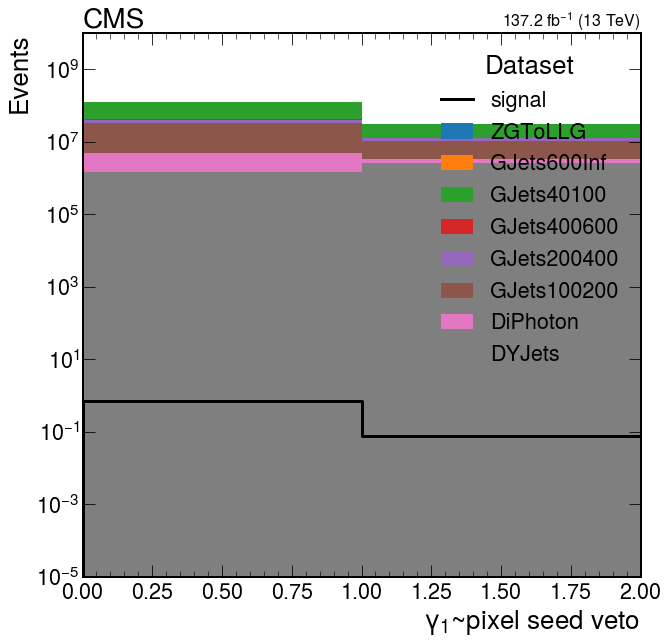

In [23]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["leading_pixel_seed_veto"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["leading_pixel_seed_veto"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

DY having the opposite pixel seed veto distribution makes sense!

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


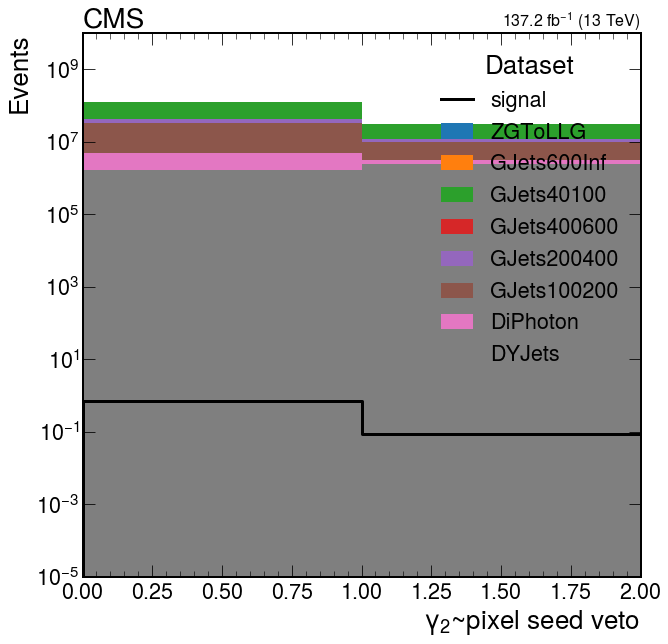

In [24]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["trailing_pixel_seed_veto"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["trailing_pixel_seed_veto"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


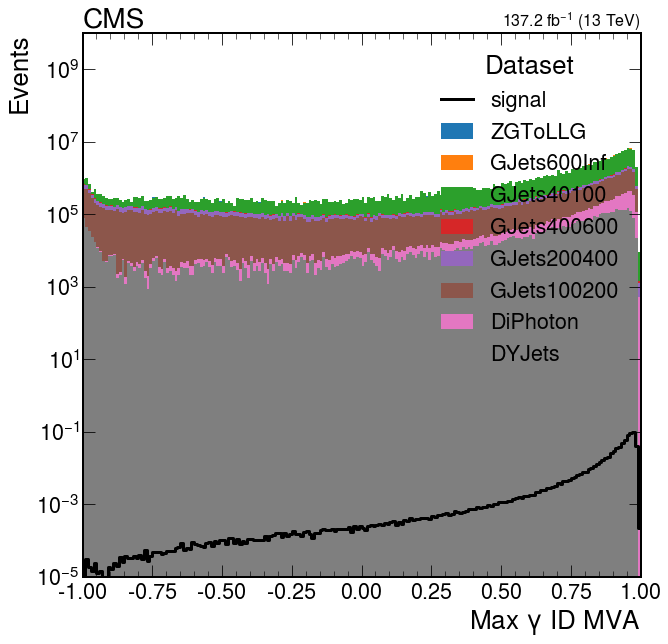

In [25]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["max_gamma_ID_MVA"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["max_gamma_ID_MVA"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


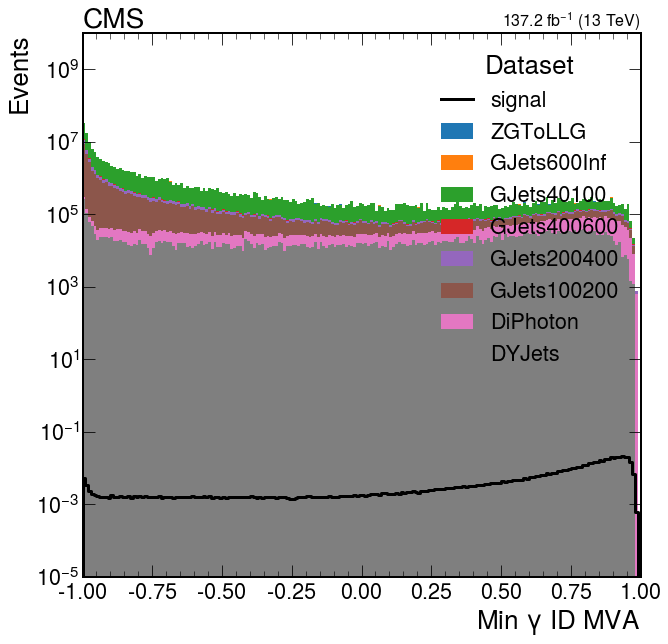

In [26]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["min_gamma_ID_MVA"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["min_gamma_ID_MVA"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


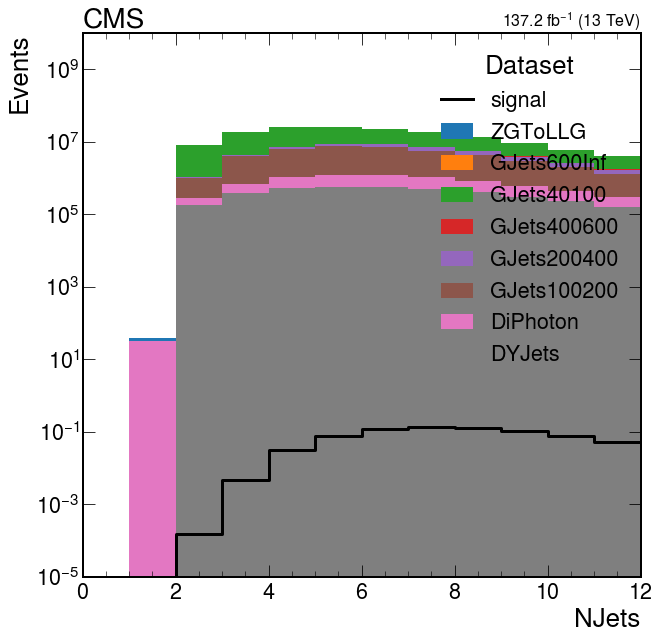

In [27]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["nJets"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["nJets"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


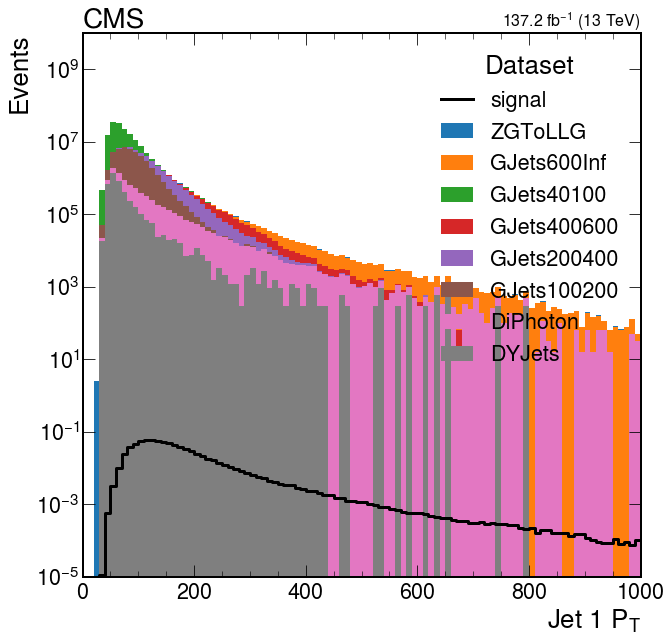

In [28]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["jet_1_pt"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["jet_1_pt"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


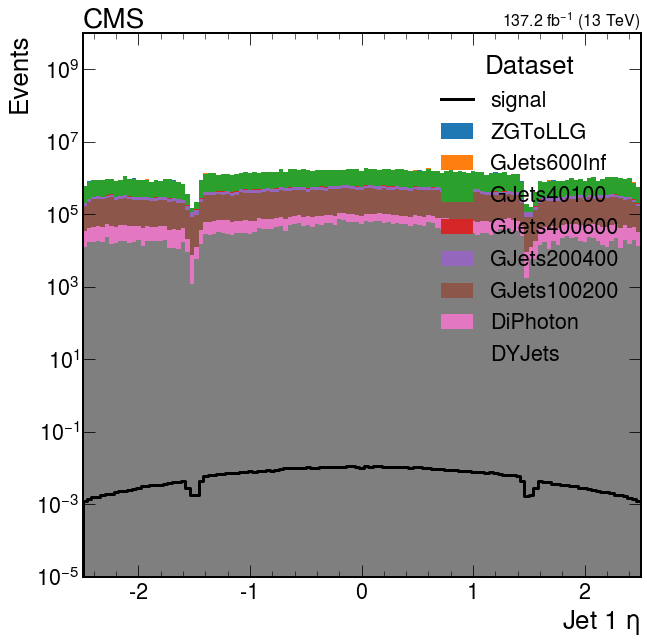

In [29]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["jet_1_eta"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["jet_1_eta"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


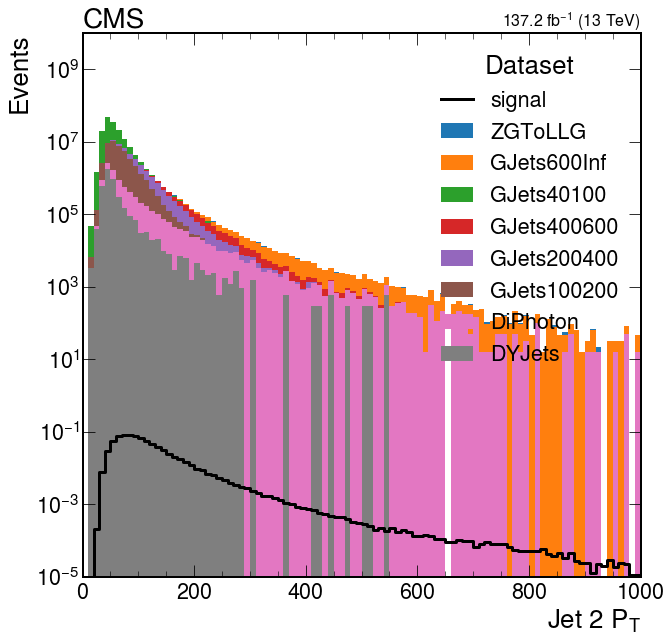

In [30]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["jet_2_pt"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["jet_2_pt"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)


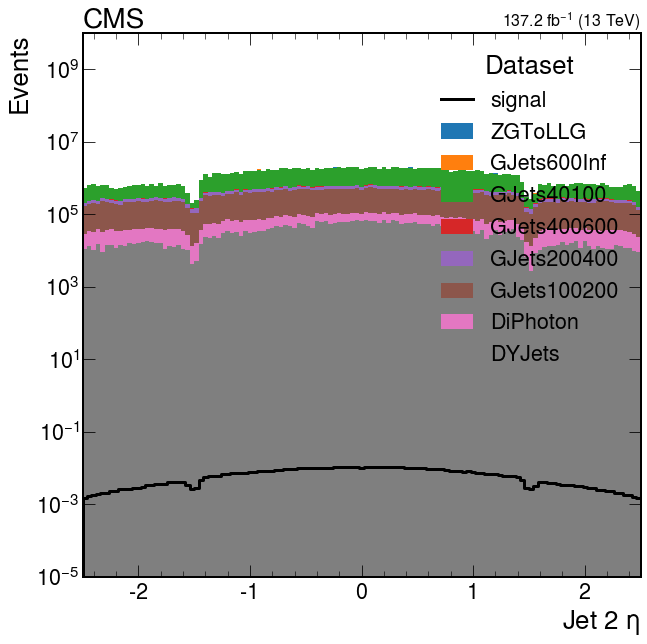

In [31]:
plt.yscale("log")
plt.ylim([1e-5,1e10])
hist.plot1d(hists["jet_2_eta"]["background"],stack = True, overlay = "dataset") #fill_opts = {
    #'alpha': 0.8,
    #'edgecolor':(0,0,0,.5)
#})

ax = hist.plot1d(hists["jet_2_eta"]["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )